<a href="https://colab.research.google.com/github/YuriySamorodov/MIPT/blob/main/student_analysis_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ успеваемости студентов

## Подготовка данных и установка библиотек

In [1]:
# Установка необходимых библиотек
!pip install pandas numpy matplotlib seaborn scikit-learn dask

In [4]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import gdown
import dask.dataframe as dd


# Настройки отображения
sns.set_theme(style="whitegrid")
%matplotlib inline

# Увеличиваем лимит вывода строк для pandas
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Загрузка данных с Google Drive

Сначала нужно загрузить файлы данных. Будем использовать gdown вместо curl или wget, так как его призводительность выше на больших файлах, он автоматически выпускает Authentication Token и так далее.
https://github.com/wkentaro/gdown

In [3]:
# Загрузка файлов в Google Colab
train_id = '1vzcGaLF0DE_WcynJgFAhD7FFeAe6EnTL'
gdown.download(id=train_id,output='train.csv')

lectures_id = '1Op7UOAJwoC9MV4LMTjOBA24jUnTrTmUK'
gdown.download(id=lectures_id,output='lectures.csv')

questions_id = '1x4ybKLXnKUdW-EINwnVG_kJmLzfOTWE1'
gdown.download(id=questions_id,output='questions.csv')



Downloading...
From (original): https://drive.google.com/uc?id=1vzcGaLF0DE_WcynJgFAhD7FFeAe6EnTL
From (redirected): https://drive.google.com/uc?id=1vzcGaLF0DE_WcynJgFAhD7FFeAe6EnTL&confirm=t&uuid=bd548941-ad0d-4c69-9069-cb68fd16880f
To: /content/train.csv
 18%|█▊        | 1.02G/5.85G [00:18<00:54, 88.8MB/s]

KeyboardInterrupt: 

## Обработка файлов

In [7]:
# Предварительно проанализируем большой файл train.csv

train_sample = pd.read_csv('train.csv',nrows=10)
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   row_id                          10 non-null     int64  
 1   timestamp                       10 non-null     int64  
 2   user_id                         10 non-null     int64  
 3   content_id                      10 non-null     int64  
 4   content_type_id                 10 non-null     int64  
 5   task_container_id               10 non-null     int64  
 6   user_answer                     10 non-null     int64  
 7   answered_correctly              10 non-null     int64  
 8   prior_question_elapsed_time     9 non-null      float64
 9   prior_question_had_explanation  9 non-null      object 
dtypes: float64(1), int64(8), object(1)
memory usage: 928.0+ bytes


In [8]:
# Будем использовать имя "train_parquet", так как метод to_parquet() генерирует набор файлов в папке и принимает на вход имя папки, куда будут сохраняться файлы.
# Использование подчеркивания вместо точки позволит визуально подтвервердить, что результат выполнения кода ниже (ddf.to_parquet) - это НЕ файл, а папка.
# Далее мы будем обращаться к папке, а не к индивидуальным файлам.

train_parquet = 'train.csv'.replace('.csv', '_parquet')

# Обратим внимание, что все числовые колонки в train.csv были импортированы с типом Int64, который позволяет хранить числа влоть до девять квинтиллионов (2^63-1), но при этом занимает требует много памяти. Исходя из содержания сэмпла, делаем вывод, что многим полям и не нужен Int64. Уже на этом этапе есть возможность для оптимизации данных.
# Потому на следующем шаге зададим типы данных. Обработка датасета займет больше времени, но размер в памяти будет гораздо меньше.
#

dtypes = {
    'row_id': pd.Int32Dtype,
    'timestamp': pd.Int64Dtype,
    'user_id': pd.Int32Dtype,
    'content_id': pd.Int16Dtype,
    'content_type_id': pd.Int8Dtype,
    'task_container_id': pd.Int16Dtype,
    'user_answer': pd.Int8Dtype,
    'answered_correctly': pd.Int8Dtype,
    'prior_question_elapsed_time': pd.Float32Dtype,
    'prior_question_had_explanation': pd.BooleanDtype
}

ddf = dd.read_csv(
    'train.csv',
    dtype=dtypes,
    engine='pyarrow',
    on_bad_lines='warn',
    skip_blank_lines=False,
    header=0
)

ddf.to_parquet(train_parquet, compression='zstd', overwrite=True)



/usr/local/lib/python3.10/dist-packages/dask/dataframe/io/csv.py:640: UserWarning: Instantiating Int32Dtype without any arguments.Pass a Int32Dtype instance to silence this warning.
  head = reader(BytesIO(b_sample), nrows=sample_rows, **head_kwargs)
/usr/local/lib/python3.10/dist-packages/dask/dataframe/io/csv.py:640: UserWarning: Instantiating Int64Dtype without any arguments.Pass a Int64Dtype instance to silence this warning.
  head = reader(BytesIO(b_sample), nrows=sample_rows, **head_kwargs)
/usr/local/lib/python3.10/dist-packages/dask/dataframe/io/csv.py:640: UserWarning: Instantiating Int16Dtype without any arguments.Pass a Int16Dtype instance to silence this warning.
  head = reader(BytesIO(b_sample), nrows=sample_rows, **head_kwargs)
/usr/local/lib/python3.10/dist-packages/dask/dataframe/io/csv.py:640: UserWarning: Instantiating Int8Dtype without any arguments.Pass a Int8Dtype instance to silence this warning.
  head = reader(BytesIO(b_sample), nrows=sample_rows, **head_kwargs

Внезапно файлы Parquet занимют всего 1.2GB! Это успех =)

In [9]:
# Посмотрим, сколько файлы parquet занимают на диске места
!du -hs /content/train_parquet/
!( find  /content/train_parquet/ -name '*.parquet' -print0 | xargs -0 cat ) | wc -l
!wc -l /content/train.csv


1.2G	/content/train_parquet/
5433129
101230333 /content/train.csv


Загружаем датафрейм из файлов Parquet

In [10]:
# Загрузка данных

train = pd.read_parquet(
    'train_parquet',
    engine='pyarrow',
)



In [5]:
# Все бы было ничего, если бы Google Colab не падал при анализе второй характеристики.
# Времени нет, загрузим данные в лоб. Просто обрежем количество строк до 1 млн.

lectures = pd.read_csv('lectures.csv')
questions = pd.read_csv('questions.csv')

dtypes = {
    'row_id': pd.Int32Dtype,
    'timestamp': pd.Int64Dtype,
    'user_id': pd.Int32Dtype,
    'content_id': pd.Int16Dtype,
    'content_type_id': pd.Int8Dtype,
    'task_container_id': pd.Int16Dtype,
    'user_answer': pd.Int8Dtype,
    'answered_correctly': pd.Int8Dtype,
    'prior_question_elapsed_time': pd.Float32Dtype,
    'prior_question_had_explanation': pd.BooleanDtype
}
train = pd.read_csv('train.csv', dtype=dtypes,nrows=10**7)

<ipython-input-5-fa0b820157aa>:19: UserWarning: Instantiating Int32Dtype without any arguments.Pass a Int32Dtype instance to silence this warning.
  train = pd.read_csv('train.csv', dtype=dtypes,nrows=10**7)
<ipython-input-5-fa0b820157aa>:19: UserWarning: Instantiating Int64Dtype without any arguments.Pass a Int64Dtype instance to silence this warning.
  train = pd.read_csv('train.csv', dtype=dtypes,nrows=10**7)
<ipython-input-5-fa0b820157aa>:19: UserWarning: Instantiating Int16Dtype without any arguments.Pass a Int16Dtype instance to silence this warning.
  train = pd.read_csv('train.csv', dtype=dtypes,nrows=10**7)
<ipython-input-5-fa0b820157aa>:19: UserWarning: Instantiating Int8Dtype without any arguments.Pass a Int8Dtype instance to silence this warning.
  train = pd.read_csv('train.csv', dtype=dtypes,nrows=10**7)
<ipython-input-5-fa0b820157aa>:19: UserWarning: Instantiating Float32Dtype without any arguments.Pass a Float32Dtype instance to silence this warning.
  train = pd.read_c

In [6]:

# Проверка загруженных данных
print("Размерности датасетов:")
print(f"train: {train.shape}")
print(f"lectures: {lectures.shape}")
print(f"questions: {questions.shape}")

Размерности датасетов:
train: (10000000, 10)
lectures: (418, 4)
questions: (13523, 5)


## Функции анализа данных

In [7]:
def analyze_general_statistics(df):
    total_answers = len(df[df['content_type_id'] == 0])
    correct_answers = len(df[(df['content_type_id'] == 0) & (df['answered_correctly'] == 1)])
    accuracy = correct_answers / total_answers * 100

    print(f"Всего ответов: {total_answers:,}")
    print(f"Правильных ответов: {correct_answers:,}")
    print(f"Общая точность: {accuracy:.2f}%")

    # Дополнительная статистика
    print("\nСтатистика по пользователям:")
    print(f"Всего пользователей: {df['user_id'].nunique():,}")
    print(f"Всего вопросов: {df[df['content_type_id'] == 0]['content_id'].nunique():,}")
    print(f"Всего лекций: {df[df['content_type_id'] == 1]['content_id'].nunique():,}")

    return accuracy

In [8]:
def analyze_response_time(df):
    response_times = df[df['prior_question_elapsed_time'].notna()]['prior_question_elapsed_time']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Гистограмма
    sns.histplot(response_times, bins=50, ax=ax1)
    ax1.set_title('Распределение времени ответов')
    ax1.set_xlabel('Время (мс)')
    ax1.set_ylabel('Количество')

    # Box plot
    sns.boxplot(y=response_times, ax=ax2)
    ax2.set_title('Box plot времени ответов')
    ax2.set_ylabel('Время (мс)')

    plt.tight_layout()
    plt.show()

    # Статистика
    print("\nСтатистика времени ответов (мс):")
    print(response_times.describe())

## Анализ данных

In [9]:
# Общая статистика
accuracy = analyze_general_statistics(train)

Всего ответов: 9,804,604
Правильных ответов: 6,457,425
Общая точность: 65.86%

Статистика по пользователям:
Всего пользователей: 39,491
Всего вопросов: 13,500
Всего лекций: 402


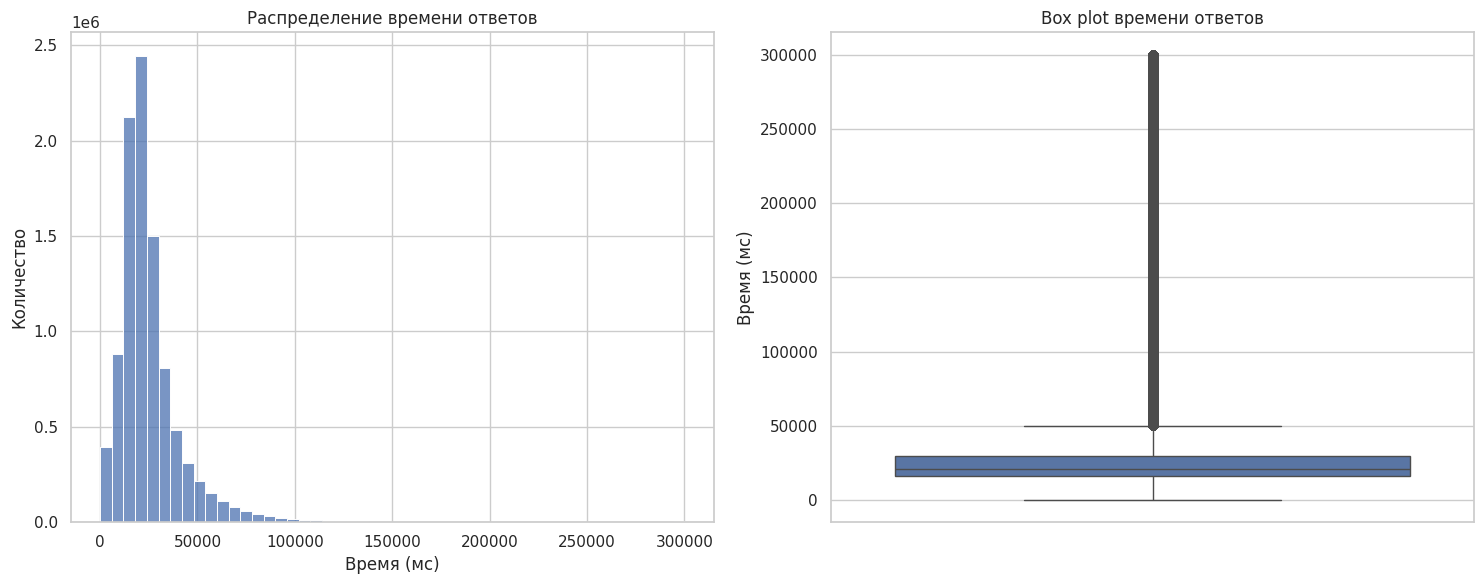


Статистика времени ответов (мс):
count       9765216.0
mean     25475.587891
std      19950.324219
min               0.0
25%           16000.0
50%           21000.0
75%           29666.0
max          300000.0
Name: prior_question_elapsed_time, dtype: Float64


In [10]:
# Анализ времени ответов
analyze_response_time(train)

## Дополнительные исследования

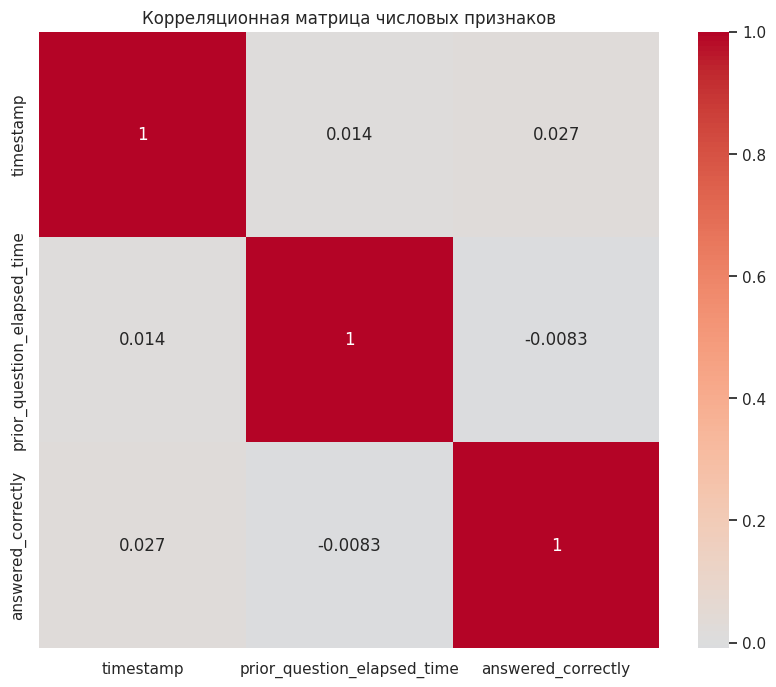

In [11]:
# Корреляционный анализ
numeric_cols = ['timestamp', 'prior_question_elapsed_time', 'answered_correctly']
correlation_matrix = train[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляционная матрица числовых признаков')
plt.show()

In [25]:
# Сохранение результатов анализа
def save_results(df):
    results = {
        'total_users': df['user_id'].nunique(),
        'total_questions': df[df['content_type_id'] == 0]['content_id'].nunique(),
        'total_lectures': df[df['content_type_id'] == 1]['content_id'].nunique(),
        'average_accuracy': df[df['content_type_id'] == 0]['answered_correctly'].mean(),
        'average_response_time': df['prior_question_elapsed_time'].mean()
    }

    results_df = pd.DataFrame([results])
    results_df.to_csv('analysis_results.csv', index=False)
    print("Результаты анализа сохранены в analysis_results.csv")

save_results(train)

Результаты анализа сохранены в analysis_results.csv
